In [147]:
import pandas  as pd
import os
from pathlib import Path

In [148]:
BASE_DIR = Path(os.path.dirname(os.path.abspath('esi-trabalho-final'))).parent

In [149]:
BASE_DIR = str(BASE_DIR)

In [150]:
data = pd.read_csv(BASE_DIR+'\\data\\'+'data.csv')

In [151]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [152]:
data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [153]:
data.nunique()

date               70
price            1741
bedrooms           10
bathrooms          26
sqft_living       566
sqft_lot         3113
floors              6
waterfront          2
view                5
condition           5
sqft_above        511
sqft_basement     207
yr_built          115
yr_renovated       60
street           4525
city               44
statezip           77
country             1
dtype: int64

In [154]:
data.nunique().index

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [155]:
data.drop('country', axis=1, inplace=True)

In [156]:
data[data['price'] <= 0]['price'].unique()

array([0.])

In [157]:
def remove_casa_free(df):
    index = df[df['price'] <= 0].index
    return df.drop(index=index)

In [158]:
data = remove_casa_free(data)

In [159]:
import tensorflow as tf
import keras

In [160]:
def tokenizer_text(data):
    vectorizer = keras.layers.TextVectorization(
        output_mode='int',
        output_sequence_length=15,
        standardize='lower_and_strip_punctuation',
    )
    # unindo colunas de
    data['location'] = data['street'] + ' ' + data['city'] + ' ' + data['statezip'] 

    # vetorizando
    vectorizer.adapt(data['location'].values)
    tokenizer_text = vectorizer(data['location'].values)

    return tokenizer_text, vectorizer.vocabulary_size()

In [161]:
subset, vocab_size = tokenizer_text(data)

In [162]:
def global_mean(token, input,embedding_dim=5):
    """Aplica GlobalAveragePooling1D para reduzir a dimensionalidade do token."""
    ebedding_dim = 5
    embedding = keras.layers.Embedding( 
        input_dim=input,
        output_dim=embedding_dim,
    )
    token = embedding(token)

    # Aplicando GlobalAveragePooling1D
    token = keras.layers.GlobalAveragePooling1D()(token)

    return token.numpy()

In [163]:
subset = global_mean(subset, vocab_size)

In [164]:
def to_colunmns(data, subset):
    for i in range(subset.shape[1]):
        data[f'char_token_{i}'] = subset[:, i]

    return data

In [165]:
def remove_columns(df, columns_to_remove):
    return df.drop(columns_to_remove, axis=1)

In [166]:
data = remove_columns(data, ['street', 'city', 'statezip', 'location'])

In [167]:
def arrendondamento(data):
    data['bathrooms'] = data['bathrooms'].astype(int)
    data['floors'] = data['floors'].astype(int)
    return data

In [168]:
from sklearn.preprocessing import StandardScaler
def padronizacao(data):
    scaler = StandardScaler()
    for i in ['sqft_living', 'sqft_lot','sqft_above', 'sqft_basement']:
        data[i] = scaler.fit_transform(data[[i]].astype(float).values)
    return data

In [169]:
data = padronizacao(data)

In [170]:
data = to_colunmns(data, subset)

In [171]:
data['char_token_0']

0       0.002701
1      -0.005977
2      -0.002439
3      -0.002474
4      -0.002944
          ...   
4595    0.003153
4596   -0.001657
4597    0.002043
4598    0.005894
4599    0.000173
Name: char_token_0, Length: 4551, dtype: float32

In [172]:
def dummies(data):
    return pd.get_dummies(data=data, columns=['floors', 'waterfront', 'view', 'condition','bedrooms','bathrooms'], dtype=int)

In [173]:
data = arrendondamento(data)

In [174]:
data = dummies(data)

In [175]:
import numpy as np
def transformacao_log(data):
    data['price'] = np.log1p(data['price'])
    return data

In [176]:
from sklearn.mixture import GaussianMixture
def gaussian_outliers(data):
    X = data['price'].values.reshape(-1, 1)

    #logging.info("Aplicando gaussian_outliers para a coluna price...")
    gm = GaussianMixture(n_components=1)
    gm.fit(X)
    

    densidade = gm.score_samples(X)
    #logging.info(f'Percentil 4: {np.percentile(densidade, 4)}')
    densidade_threshold = np.percentile(densidade, 10)

    # Máscara booleana para identificar outliers
    outlier_mask = densidade < densidade_threshold

    # Índices dos outliers
    outlier_indices = data.index[outlier_mask]

    print(f'Quantidade de outliers: {len(outlier_indices)}')

    # Retorna DataFrame sem os outliers
    return data.drop(index=outlier_indices)

In [177]:
data = gaussian_outliers(data)

Quantidade de outliers: 455


In [178]:
data = transformacao_log(data)

<Axes: >

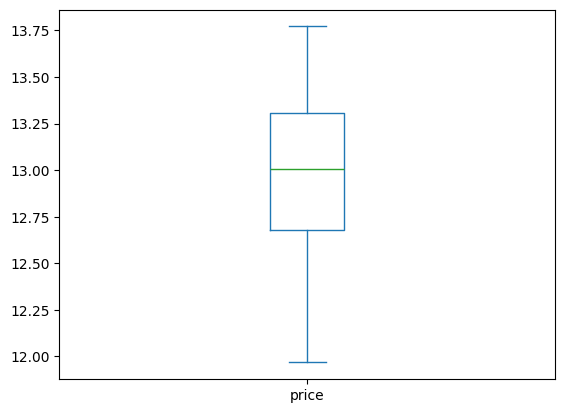

In [179]:
data['price'].plot.box()

In [180]:
X = data.drop(['price','date'], axis=1).values

In [181]:
y = data['price'].values

In [182]:
data

,date,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,char_token_0,char_token_1,...,bedrooms_8.0,bedrooms_9.0,bathrooms_0,bathrooms_1,bathrooms_2,bathrooms_3,bathrooms_4,bathrooms_5,bathrooms_6,bathrooms_8
0,2014-05-02 00:00:00,12.653962,-0.828976,-0.192527,-0.564425,-0.671413,1955,2005,0.002701,-0.006705,...,0,0,0,1,0,0,0,0,0,0
2,2014-05-02 00:00:00,12.742569,-0.211721,-0.080319,0.126151,-0.671413,1966,0,-0.002439,-0.006770,...,0,0,0,0,1,0,0,0,0,0
3,2014-05-02 00:00:00,12.948012,-0.138487,-0.189245,-0.962384,1.493385,1963,0,-0.002474,-0.007003,...,0,0,0,0,1,0,0,0,0,0
4,2014-05-02 00:00:00,13.217675,-0.201259,-0.120558,-0.798519,1.060425,1976,1992,-0.002944,0.001634,...,0,0,0,0,1,0,0,0,0,0
5,2014-05-02 00:00:00,13.102163,-1.310226,-0.235129,-1.102840,-0.671413,1938,1994,0.002813,0.001430,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,12.638399,-0.651123,-0.235686,-0.365446,-0.671413,1954,1979,0.003153,-0.000019,...,0,0,0,1,0,0,0,0,0,0
4596,2014-07-09 00:00:00,13.188777,-0.703433,-0.201954,-0.423969,-0.671413,1983,2009,-0.001657,-0.000697,...,0,0,0,0,1,0,0,0,0,0
4597,2014-07-09 00:00:00,12.940614,0.918170,-0.217499,1.390257,-0.671413,2009,0,0.002043,-0.002469,...,0,0,0,0,1,0,0,0,0,0
4598,2014-07-10 00:00:00,12.222935,-0.044330,-0.228177,-0.880452,1.536681,1974,0,0.005894,-0.002395,...,0,0,0,0,1,0,0,0,0,0


### modelo 1

In [183]:
from sklearn.ensemble import RandomForestRegressor

In [184]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [185]:
from sklearn.metrics import mean_squared_error, r2_score

In [186]:
mean_squared_error(y, rf.predict(X))

0.01144929102038197

In [187]:
r2_score(y, rf.predict(X))

0.9318804552575238

In [188]:
from sklearn.linear_model import SGDRegressor

In [189]:
sgd = SGDRegressor()
sgd.fit(X, y)

SGDRegressor()

In [190]:
mean_squared_error(y, sgd.predict(X))

1.845471268672345e+30

In [191]:
r2_score(y, sgd.predict(X))

-1.0979951722205937e+31

In [192]:
from sklearn.svm import SVR

In [193]:
svr = SVR()
svr.fit(X, y)

SVR()

In [194]:
svr.score(X, y) 

0.006529908106768123

In [195]:
r2_score(y, svr.predict(X))

0.006529908106768123

In [196]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [197]:
lr.score(X, y)

0.46868337585487396

In [198]:
r2_score(y, lr.predict(X))

0.46868337585487396

In [199]:
mean_squared_error(np.expm1(y), np.expm1(lr.predict(X)))

20349621920.384956

In [200]:
r2_score(np.expm1(y), np.expm1(lr.predict(X)))

0.4242178088698523

In [201]:
from sklearn.linear_model import RANSACRegressor

In [202]:
ransac = RANSACRegressor(
    estimator=LinearRegression(),
    max_trials=100
)

ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression())

In [203]:
ransac.score(X, y)

0.3794116887542959

In [204]:
y_pred = np.expm1(ransac.predict(X))

In [205]:
r2_score(np.expm1(y), y_pred)

0.20836601157477408